# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---



## Camera calibration using chessboard images

Import require libraries

In [45]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

Display all the chessboard images

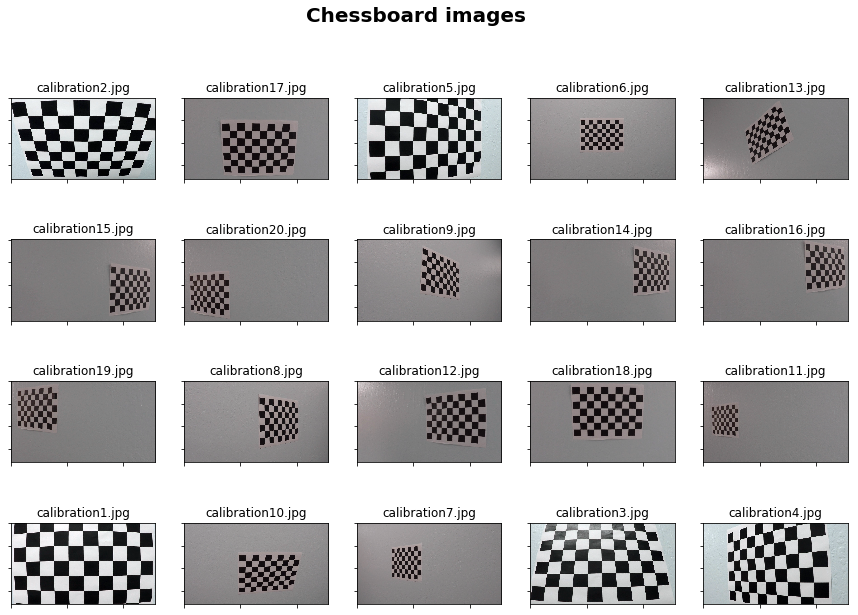

In [38]:
cam_dir = "camera_cal/"
chess_imgs = []

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
plt.suptitle('Chessboard images', fontsize=20, fontweight='bold')
for i, jpg_name in enumerate(os.listdir(cam_dir)):
    img = cv2.imread(cam_dir + jpg_name)
    chess_imgs.append(img)
    ax = ax.ravel()
    ax[i].imshow(img)
    ax[i].set_title(jpg_name)
    
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax.ravel()], visible=False)
plt.draw()    

### Extract the camera calibration points

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Chessboard x : 9, y : 6

In [31]:
chess_corners_x = 9
chess_corners_y = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chess_corners_x * chess_corners_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:chess_corners_x,0:chess_corners_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

chess_calib_imgs = []

# Step through the list and search for chessboard corners
for img in chess_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_corners_x, chess_corners_y),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        proc_img = cv2.drawChessboardCorners(img, (chess_corners_x, chess_corners_y), corners, ret)
        chess_calib_imgs.append(proc_img)

print("Done findChessboardCorners.")

findChessboardCorners Done


Draw chessboard corner images

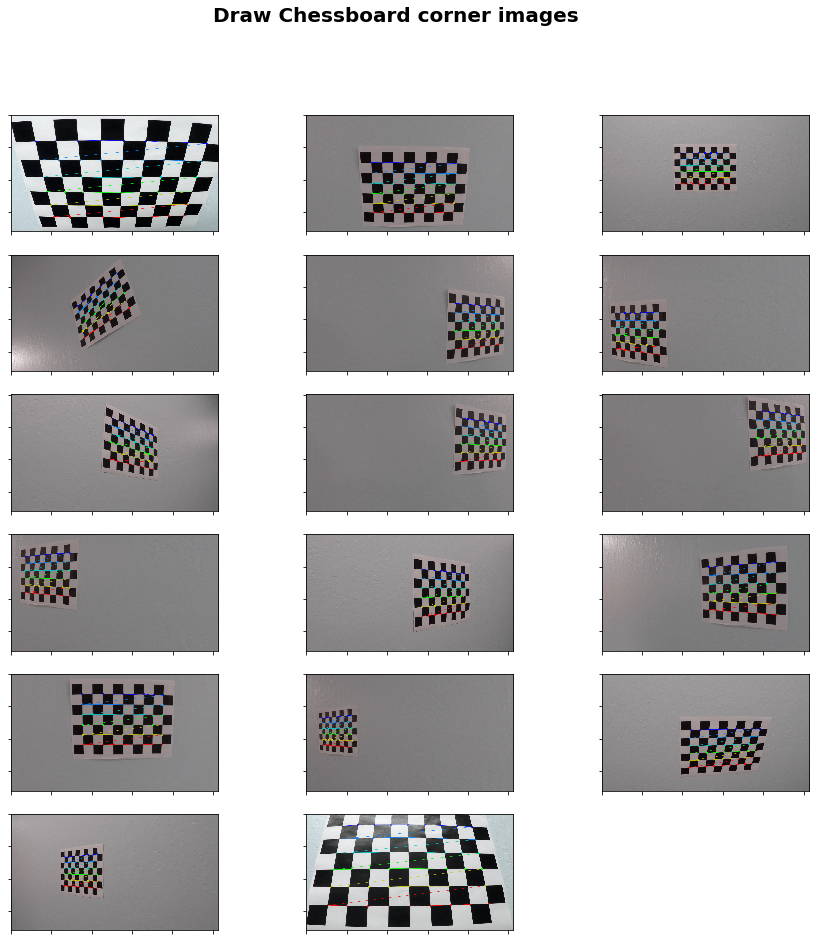

In [39]:
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
plt.suptitle('Draw Chessboard corner images', fontsize=20, fontweight='bold')
for i, img in enumerate(chess_calib_imgs):
    ax = ax.ravel()
    ax[i].imshow(img)

ax[17].axis('off')
    
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax.ravel()], visible=False)
plt.draw()

### Save and load calibration points

Save chessboard corner calibration points

In [47]:
chess_pickle = "chessboard_corner_points.pickle"
if not os.path.isfile(chess_pickle):
    print('Saving data to pickle file...')
    try:
        with open(chess_pickle, 'wb') as pfile:
            pickle.dump(
                {
                    'objpoints': objpoints,
                    'imgpoints': imgpoints,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', chess_pickle, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


Load chessboard corner calibration points

In [49]:
chess_pickle = "chessboard_corner_points.pickle"

if os.path.isfile(chess_pickle):
    dist_pickle = pickle.load( open( chess_pickle, "rb" ) )
    objpoints = dist_pickle["objpoints"]
    imgpoints = dist_pickle["imgpoints"]
    print("Load data sucessfully.")
else:
    print("Load data failed.")

Load data sucessfully.


Function that performs image distortion correction

In [50]:
def correct_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Test on a distorted image and display the undistorted image

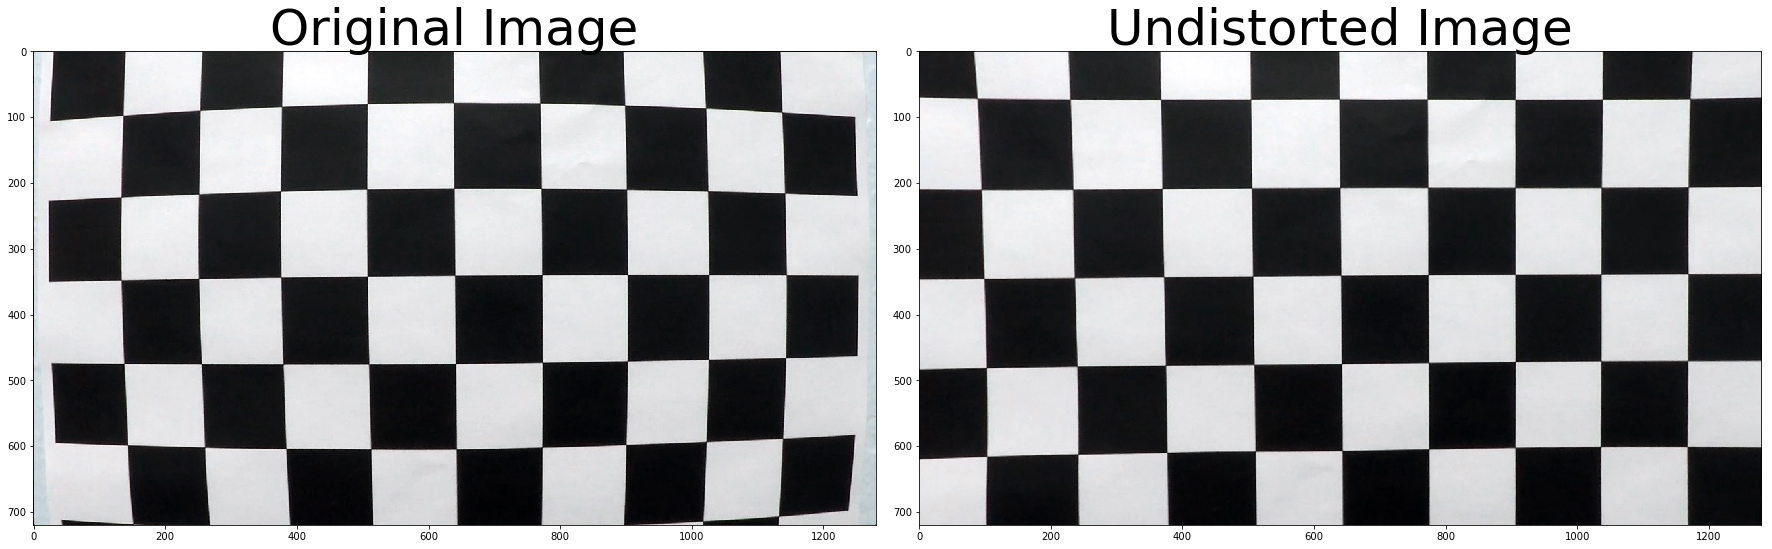

In [51]:
test_distorted_img_name = "camera_cal/calibration1.jpg"
test_distorted_img = cv2.imread(test_distorted_img_name)

test_undistorted_img = correct_undistort(test_distorted_img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_distorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a distortion correction to raw images